In [45]:
!nvidia-smi

Sun Dec  4 22:56:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    32W /  70W |   6842MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:

!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf/download?datasetVersionNumber=1')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vid1986hya
Your Kaggle Key: ··········


100%|██████████| 179M/179M [00:09<00:00, 19.2MB/s]


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
d_set = tf.keras.preprocessing.image_dataset_from_directory(
    "tomatoleaf/tomato/train",
    shuffle = True,
    image_size= (256,256),
    batch_size = 32
    )

Found 10000 files belonging to 10 classes.


In [5]:
cls_nms = d_set.class_names
cls_nms

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
len(d_set)

313

In [7]:

313*32

10016

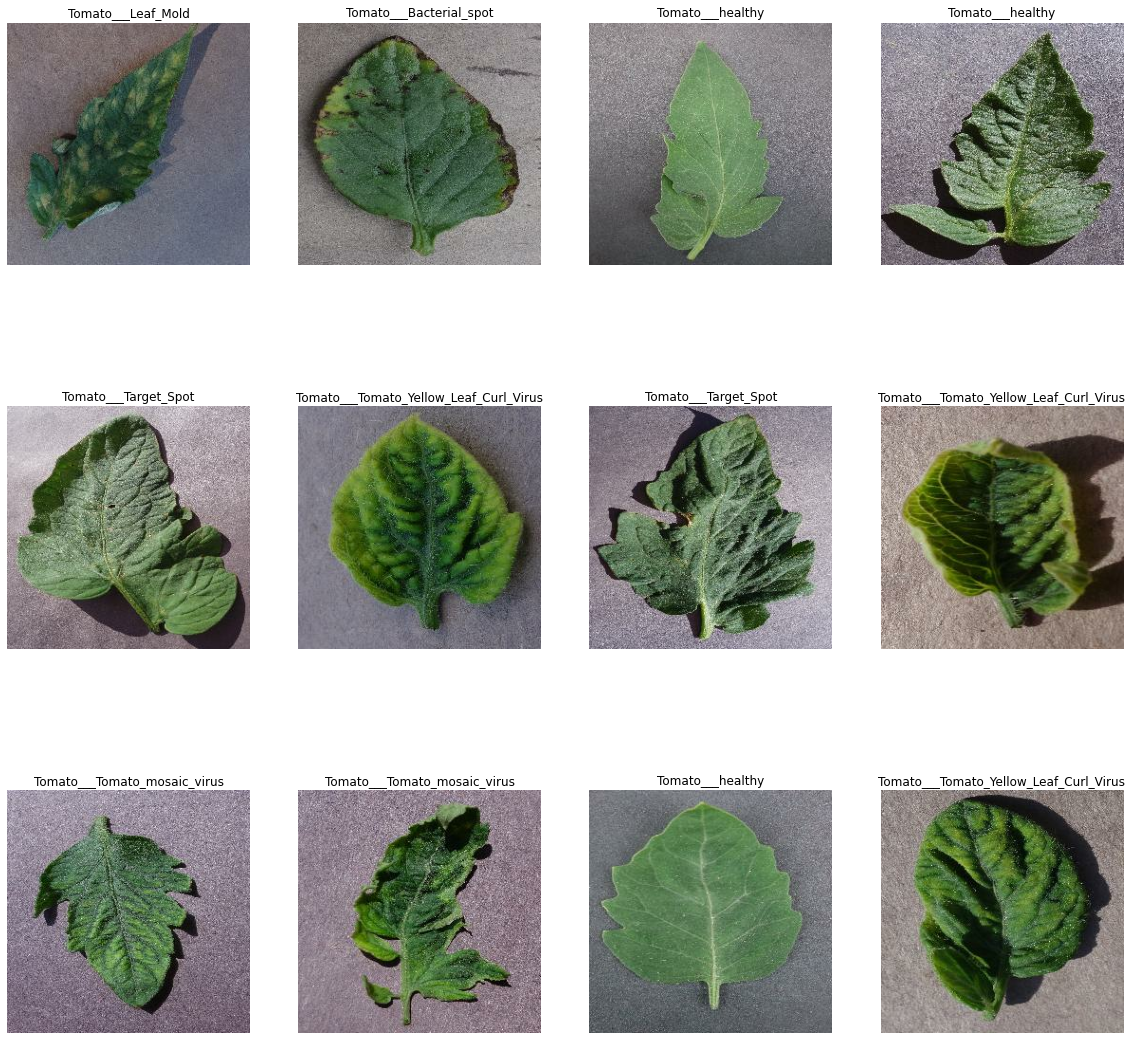

In [ ]:
plt.figure(figsize=(20,20))
for img_batch, lbl_batch in d_set.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(img_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(cls_nms[lbl_batch[i]])

In [8]:
trn_size = 0.8
len(d_set)*trn_size

250.4

In [9]:
trn_d_set = d_set.take(250)
len(trn_d_set)

250

In [10]:
test_d_set = d_set.skip(250)
len(test_d_set)

63

In [11]:
vald_size = 0.1
len(d_set)*vald_size

31.3

In [12]:
vald_d_set = test_d_set.take(31)
len(vald_d_set)

31

In [13]:
test_d_set = test_d_set.skip(31)
len(test_d_set)

32

In [14]:
trn_d_set =trn_d_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
vald_d_set =vald_d_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_d_set =test_d_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

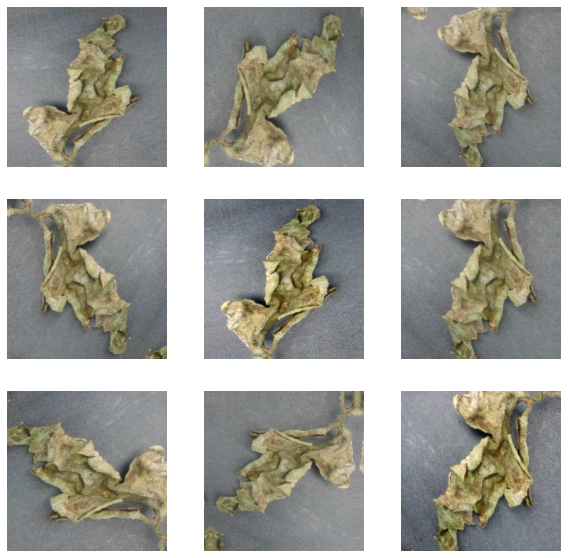

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in trn_d_set.take(1):
  for i in range(9):
    augmented_images = data_aug(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
input_shape = (32,256,256,3)
n_classes = 10
model0 = models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation ='softmax')
       
])
model0.build(input_shape=input_shape)

In [44]:
model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model0.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [20]:
r0 = model0.fit(
    trn_d_set,
    epochs=50,
    batch_size = 32,
    verbose =1,
    validation_data = vald_d_set
)

Epoch 1/50


250/250 [==============================] - 77s 227ms/step - loss: 1.9425 - accuracy: 0.2702 - val_loss: 1.7825 - val_accuracy: 0.3881
Epoch 2/50
250/250 [==============================] - 47s 187ms/step - loss: 1.4763 - accuracy: 0.4620 - val_loss: 1.6425 - val_accuracy: 0.4435
Epoch 3/50
250/250 [==============================] - 47s 187ms/step - loss: 1.2315 - accuracy: 0.5621 - val_loss: 1.2728 - val_accuracy: 0.5544
Epoch 4/50
250/250 [==============================] - 47s 187ms/step - loss: 1.0058 - accuracy: 0.6417 - val_loss: 1.3260 - val_accuracy: 0.6099
Epoch 5/50
250/250 [==============================] - 47s 186ms/step - loss: 0.8570 - accuracy: 0.6873 - val_loss: 1.5277 - val_accuracy: 0.5474
Epoch 6/50
250/250 [==============================] - 47s 187ms/step - loss: 0.7835 - accuracy: 0.7170 - val_loss: 1.7432 - val_accuracy: 0.5202
Epoch 7/50
250/250 [==============================] - 48s 190ms/step - loss: 0.6963 - accuracy: 0.7515 - val_loss: 1.6146 - val_accuracy: 0.5

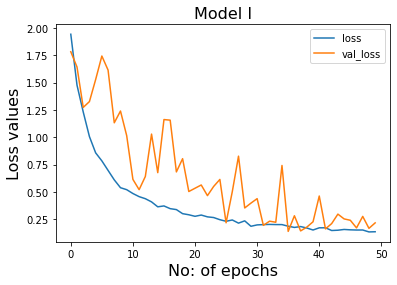

In [28]:
plt.plot(r0.history['loss'],label = 'loss')
plt.plot(r0.history['val_loss'],label = 'val_loss')
plt.xlabel('No: of epochs',fontsize = 16)
plt.ylabel('Loss values', fontsize =16)
plt.title('Model I',fontsize =16)
plt.legend()

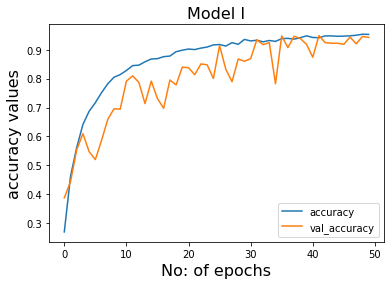

In [27]:
plt.plot(r0.history['accuracy'],label = 'accuracy')
plt.plot(r0.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('No: of epochs',fontsize = 16)
plt.ylabel('accuracy values', fontsize =16)
plt.title('Model I',fontsize =16)
plt.legend()

In [29]:
model0.evaluate(test_d_set,return_dict = True)

32/32 [==============================] - 11s 41ms/step - loss: 0.2397 - accuracy: 0.9246


{'loss': 0.23974214494228363, 'accuracy': 0.9246031641960144}

In [30]:
labels = ['Tomato___Bacterial_spot',
          'Tomato___Early_blight',
         'Tomato___Late_blight',
         'Tomato___Leaf_Mold',
         'Tomato___Septoria_leaf_spot',
         'Tomato___Spider_mites Two-spotted_spider_mite',
         'Tomato___Target_Spot',
         'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
         'Tomato___Tomato_mosaic_virus',
         'Tomato___healthy']

In [31]:
def actual0_and_predicted0(d_set): 
 
  actual0 = [labels for _, labels in d_set.unbatch()]
  predicted0 = model0.predict(d_set)

  actual0 = tf.stack(actual0, axis=0)
  predicted0 = tf.concat(predicted0, axis=0)
  predicted0 = tf.argmax(predicted0, axis=1)

  return actual0, predicted0

In [36]:
def cmatrix0(actual0, predicted0, labels, ds_type):
  cm = tf.math.confusion_matrix(actual0, predicted0)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix- Model I - testing')
  ax.set_xlabel('Predicted Truth',fontsize=14)
  ax.set_ylabel('Actual Truth',fontsize=14)
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

250/250 [==============================] - 7s 29ms/step


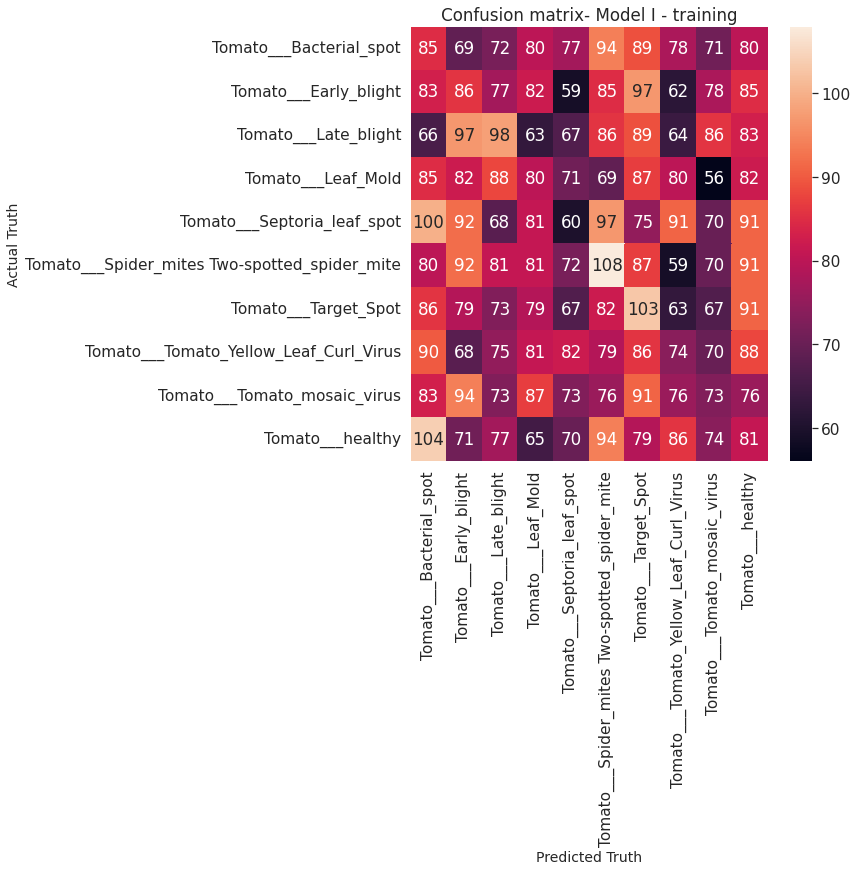

In [35]:
actual0, predicted0 = actual0_and_predicted0(trn_d_set)
cmatrix0(actual0, predicted0, labels, 'training')

32/32 [==============================] - 1s 28ms/step


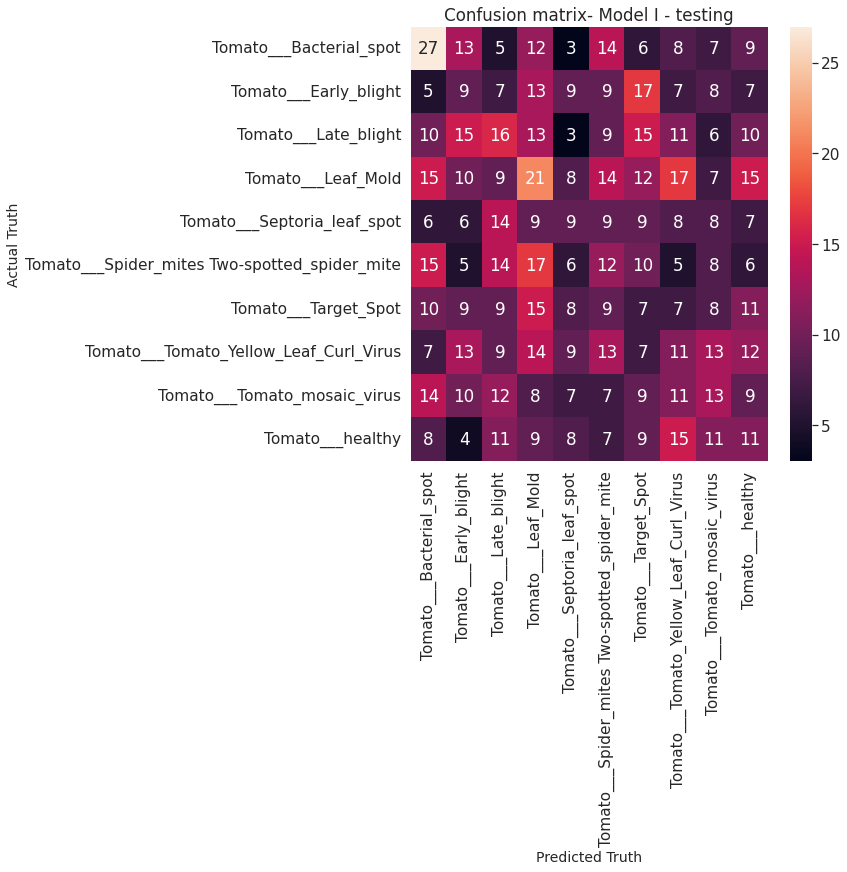

In [37]:
actual0, predicted0 = actual0_and_predicted0(test_d_set)
cmatrix0(actual0, predicted0, labels, 'test')

In [38]:
def metrics0(y_actual,y_pred, labels):
  
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) 
  precision0 = dict()
  recall0 = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] 

    row = cm[i, :]
    fn = np.sum(row) - tp[i] 

    precision0[labels[i]] = tp[i] / (tp[i] + fp) 

    recall0[labels[i]] = tp[i] / (tp[i] + fn) 

  return precision0, recall0

In [39]:
precision0, recall0 = metrics0(actual0, predicted0, labels)

In [40]:
precision0

{'Tomato___Bacterial_spot': 0.23076923076923078,
 'Tomato___Early_blight': 0.09574468085106383,
 'Tomato___Late_blight': 0.1509433962264151,
 'Tomato___Leaf_Mold': 0.16030534351145037,
 'Tomato___Septoria_leaf_spot': 0.12857142857142856,
 'Tomato___Spider_mites Two-spotted_spider_mite': 0.11650485436893204,
 'Tomato___Target_Spot': 0.06930693069306931,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 0.11,
 'Tomato___Tomato_mosaic_virus': 0.14606741573033707,
 'Tomato___healthy': 0.1134020618556701}

In [41]:
recall0

{'Tomato___Bacterial_spot': 0.25961538461538464,
 'Tomato___Early_blight': 0.0989010989010989,
 'Tomato___Late_blight': 0.14814814814814814,
 'Tomato___Leaf_Mold': 0.1640625,
 'Tomato___Septoria_leaf_spot': 0.10588235294117647,
 'Tomato___Spider_mites Two-spotted_spider_mite': 0.12244897959183673,
 'Tomato___Target_Spot': 0.07526881720430108,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 0.10185185185185185,
 'Tomato___Tomato_mosaic_virus': 0.13,
 'Tomato___healthy': 0.11827956989247312}

In [42]:
import numpy as np
def predict(model0,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model0.predict(img_array)
    predicted_class = cls_nms[np.argmax(predictions[0])]
    return predicted_class

1/1 [==============================] - 0s 37ms/step


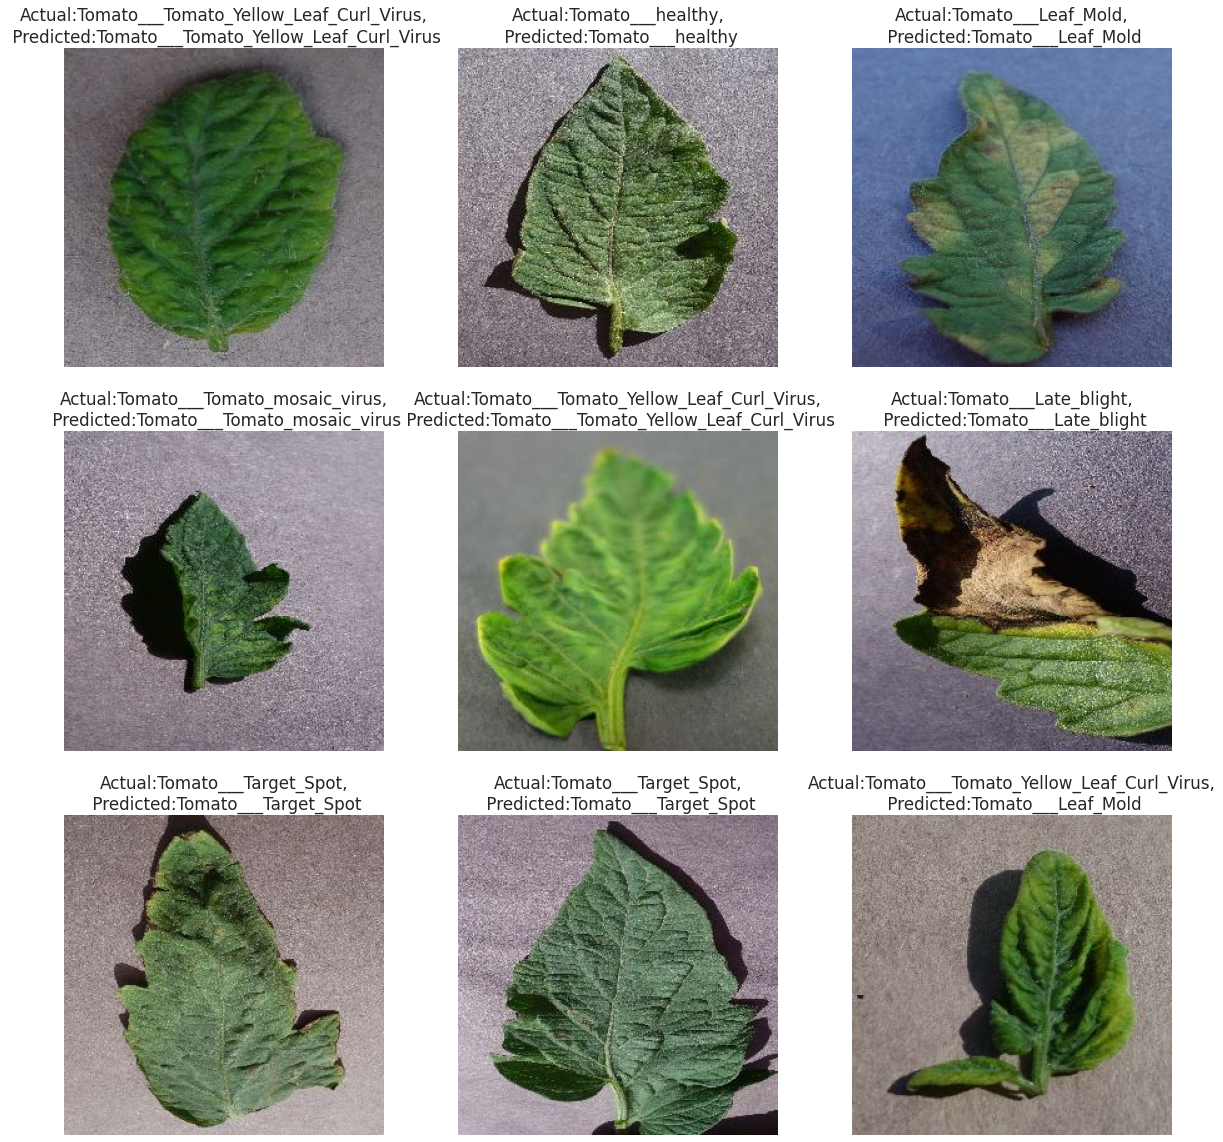

In [43]:
import numpy as np
plt.figure(figsize=(20,20))
for images, labels in test_d_set.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = predict(model0, images[i].numpy())
        actual_class = cls_nms[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}")
        plt.axis("off")
        